# Executive Certificate Big Data - Centrale Supelec - Octobre 2018
# Détection d’intrusion réseau à l’aide de l’apprentissage automatique
### Notebook : sp3-02_classification-model
### Auteur : Ahmed Mekaouar

# IP flows classification using supervised learning

In [2]:
import os
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
# Metrics based on sklearn implementation
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score
def model_metrics(y_test,y_test_pred,average):
    print( 'Accuracy: %.4f' %accuracy_score(y_test,y_test_pred))
    print( 'Precision: %.4f' %precision_score(y_test,y_test_pred,average=average))
    print( 'Recall: %.4f' %recall_score(y_test,y_test_pred,average=average))
    print( 'F1: %.4f' %f1_score(y_test,y_test_pred,average=average))

In [4]:
# The following are customised metrics that consider only 2 classes:
# Positive class : All attacks
# Negative class : BENIGN traffic
# An attack with is misclassified as another attack will be considered as be well classified 
# Accuracy result will be different from the one implemented in sci-kit learn
def model_metrics_custom(y_test,y_test_pred):
    y_test_list= list(y_test)
    y_test_pred_list=list(y_test_pred)
    benign_indexes = [index for index, v in enumerate(y_test_list) if v == 'BENIGN']
    pred_benign_indexes = [index for index, v in enumerate(y_test_pred_list) if v == 'BENIGN']
    attacks_indexes = [index for index, v in enumerate(y_test_list) if v != 'BENIGN']
    pred_attacks_indexes = [index for index, v in enumerate(y_test_pred_list) if v != 'BENIGN']
    # true_negatives are BENIGN traffic predicted as BENIGN
    # true_positives are ATTACKS traffic predicted as ATTACKS
    # false_positives are BENIGN traffic predicted as ATTACKS
    # false_negatives are ATTACKS predicted as BENIGN
    tn = len(list(set(benign_indexes).intersection(pred_benign_indexes)))
    tp = len(list(set(attacks_indexes).intersection(pred_attacks_indexes)))
    fp = len(list(set(benign_indexes).intersection(pred_attacks_indexes)))
    fn = len(list(set(attacks_indexes).intersection(pred_benign_indexes)))
    
    accuracy = (tn+tp)/(tn+tp+fp+fn)
    precision = tp /(tp+fp)
    recall = tp /(tp+fn)
    f1 = 2/((1/precision)+(1/recall))
    
    print( 'Accuracy custo: %.4f' %accuracy)
    print( 'Precision custo: %.4f' %precision)
    print( 'Recall custo: %.4f' %recall )
    print( 'F1 custo: %.4f' %f1 )

In [5]:
# This code is an adpatation from "TP machine learning - executive certificate big data - Centrale Sup Elec - C. Kermorvant"
# Better display of the confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    #print(cm)
    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
  
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load attack data

In [6]:
processed_data_path = os.path.join(os.path.pardir,'data','processed')
baseline_file_path = os.path.join(processed_data_path, 'train_baseline.csv')
attacks_file_path = os.path.join(processed_data_path, 'train_attacks.csv')

In [7]:
df = pd.concat([pd.read_csv(baseline_file_path ),pd.read_csv(attacks_file_path )])

### Balancing the dataset : Undersampling majority class (random sample)and oversampling all other classes (SMOTE)

In [8]:
columns = list(df)
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.20, random_state=1)

# I only take 10% of BENIGN traffic then use SMOTE library to fix data unbalance issue
# Taking all traning values results in a memory error (only 8GB ram)
X_train = pd.concat([X_train[X_train.Label=='BENIGN'].sample(frac=0.1,random_state=0),X_train[X_train.Label!='BENIGN']])
y_train = X_train['Label']
X_train = X_train.drop(columns=['Label'],axis=1)

In [9]:
pd.Series(y_train).value_counts()

BENIGN                      169129
DoS Hulk                    154814
PortScan                    114550
DDoS                         29328
DoS GoldenEye                 6911
FTP-Patator                   5763
SSH-Patator                   4246
DoS slowloris                 3907
Bot                           1389
Web Attack Brute Force        1015
Web Attack XSS                 436
Infiltration                    26
Web Attack Sql Injection        11
Heartbleed                       7
Name: Label, dtype: int64

In [11]:
# Oversampling minority classes sing SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='auto', random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res)
X_train_res['Label'] = y_train_res
X_train_res.columns = columns
X_train = X_train_res

y_train = X_train['Label']
X_train = X_train.drop(columns=['Label'],axis=1)

In [12]:
y_test = X_test['Label']
X_test = X_test.drop(columns=['Label'],axis=1)

##  Classification using Naive Bayes model

### Features scaling - Train and test data need to be trained separately with the same scaler

In [13]:
%%time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fit is done only with training data
X_test_scaled = scaler.transform(X_test) 

Wall time: 7.14 s


In [14]:
%%time
from sklearn.naive_bayes import GaussianNB
clf_GNB = GaussianNB()
clf_GNB.fit(X_train_scaled,y_train)

Wall time: 8.55 s


In [15]:
%%time
y_test_pred = clf_GNB.predict(X_test_scaled)

Wall time: 3.53 s


In [14]:
model_metrics(y_test,y_test_pred,'weighted')

Accuracy: 0.5697
Precision: 0.9165
Recall: 0.5697
F1: 0.6670


In [15]:
model_metrics(y_test,y_test_pred,'macro')

Accuracy: 0.5697
Precision: 0.3080
Recall: 0.7890
F1: 0.3392


In [16]:
model_metrics_custom(y_test, y_test_pred)

Accuracy custo: 0.5927
Precision custo: 0.2822
Recall custo: 0.9986
F1 custo: 0.4400


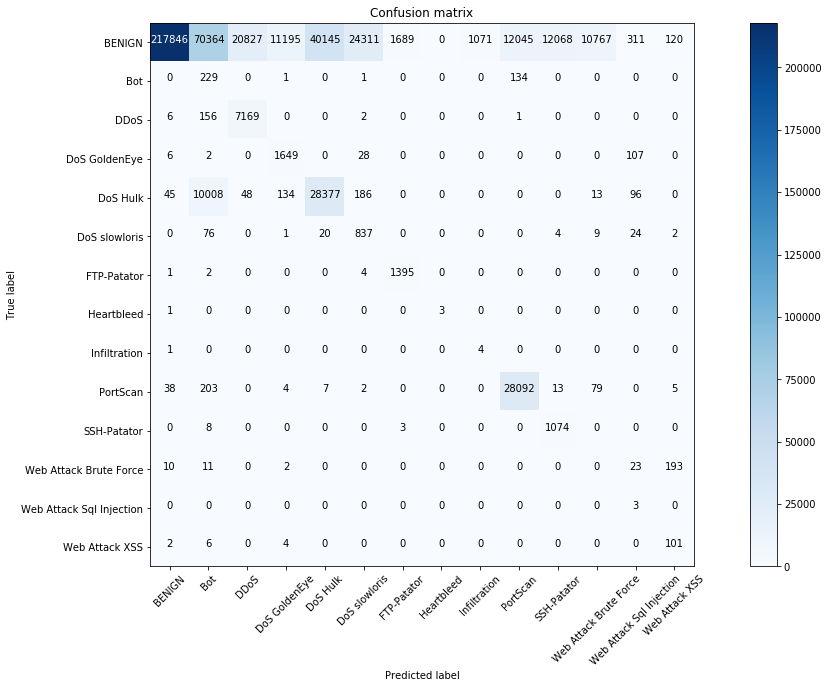

In [17]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_mat,classes=sorted(y_test.unique()))

##  Classification using Decision Tree model

In [17]:
%%time
from sklearn.tree import DecisionTreeClassifier
clf_DT = DecisionTreeClassifier( random_state = 0)
clf_DT.fit(X_train,y_train)

Wall time: 2min 13s


In [18]:
# Save classifier
from sklearn.externals import joblib
DT_classifier_file = os.path.join(os.path.pardir,'models','classification_DT_model.pkl')
joblib.dump(clf_DT, DT_classifier_file)

['..\\models\\classification_DT_model.pkl']

In [38]:
#from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
import pydotplus
dot_data = tree.export_graphviz(clf_DT, out_file=None,
                                feature_names=list(X),
                                class_names = clf_DT.classes_)
graph = graphviz.Source(dot_data)  
#graph.render("tree") # can be used to have a pdf graphe but too big...

In [ ]:
graph
# The decisions tree is too big to be interpreted !!!

In [19]:
%%time
y_test_pred = clf_DT.predict(X_test)

Wall time: 328 ms


In [20]:
model_metrics(y_test,y_test_pred,'weighted')

Accuracy: 0.9741
Precision: 0.9873
Recall: 0.9741
F1: 0.9789


In [21]:
model_metrics(y_test,y_test_pred,'macro')

Accuracy: 0.9741
Precision: 0.6526
Recall: 0.8642
F1: 0.7103


In [22]:
model_metrics_custom(y_test, y_test_pred)

Accuracy custo: 0.9745
Precision custo: 0.8688
Recall custo: 0.9902
F1 custo: 0.9255


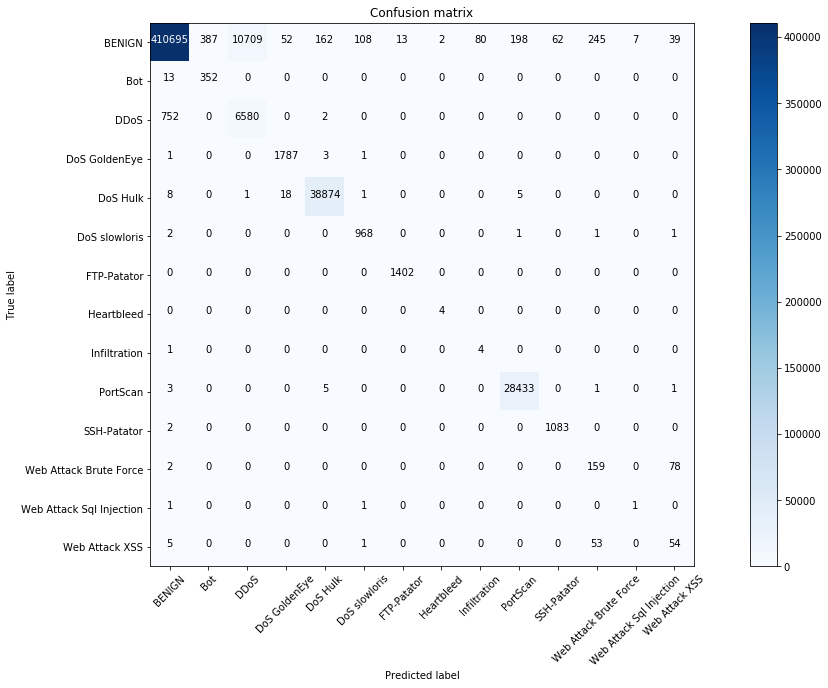

In [24]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_mat,classes=sorted(y_test.unique()))

##  Classification using Random Forests model

In [20]:
%%time
# Train the model
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=200,
                                n_jobs=-1,
                                random_state=0,
                                class_weight='balanced',
                                oob_score=True,
                                verbose=1,
                                max_features = 'sqrt',
                                min_samples_leaf = 1 )
clf_RF.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 21.2min finished


Wall time: 23min 12s


In [21]:
clf_RF

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=0,
            verbose=1, warm_start=False)

In [23]:
# Save classifier
from sklearn.externals import joblib
RF_classifier_file = os.path.join(os.path.pardir,'models','classification_RF_model.pkl')
joblib.dump(clf_RF, RF_classifier_file)

['..\\models\\classification_RF_model.pkl']

In [ ]:
# Load classifier
from sklearn.externals import joblib
RF_model_file = os.path.join(os.path.pardir,'models','classification_RF_model.pkl')
clf_RF = joblib.load(RF_model_file)

In [24]:
clf_RF.oob_score_

0.99570741859763845

In [25]:
%%time
y_test_pred = clf_RF.predict(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.2s


Wall time: 12.2 s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   11.6s finished


In [26]:
model_metrics(y_test,y_test_pred,'weighted')

Accuracy: 0.9715
Precision: 0.9881
Recall: 0.9715
F1: 0.9774


In [27]:
model_metrics(y_test,y_test_pred,'macro')

Accuracy: 0.9715
Precision: 0.7158
Recall: 0.8674
F1: 0.7604


In [28]:
model_metrics_custom(y_test, y_test_pred)

Accuracy custo: 0.9719
Precision custo: 0.8524
Recall custo: 0.9970
F1 custo: 0.9191


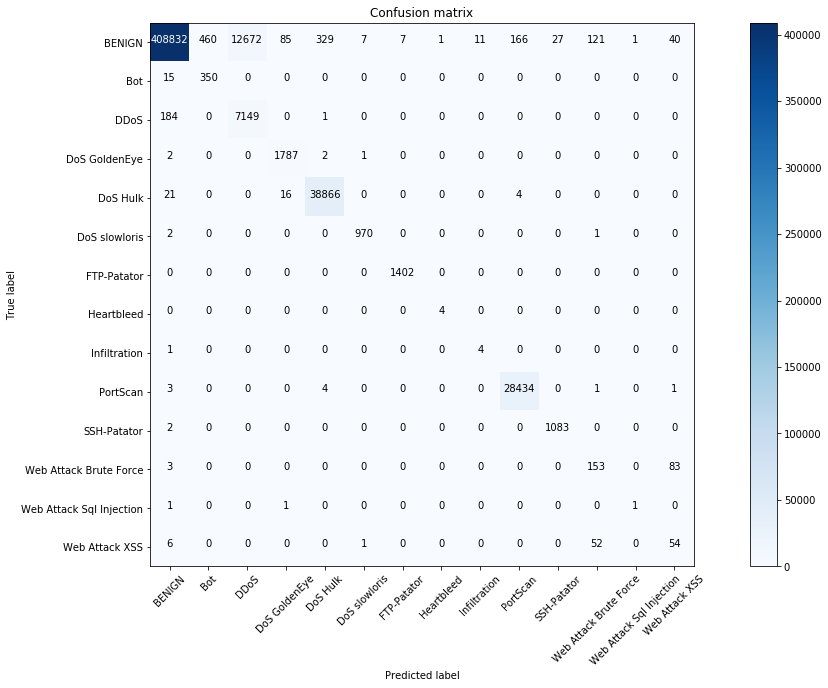

In [29]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_mat,classes=sorted(y_test.unique()))

## Model tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_features': ["sqrt", 0.3],
    'min_samples_leaf': [2,10],
    'n_estimators': [100]
}
RF = RandomForestClassifier()
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, cv = 3, n_jobs = 3, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 123.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 123.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 0.3], 'min_samples_leaf': [2, 10], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [12]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
grid_search.best_params_

{'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 100}

## Model interpretation
## Source : http://blog.datadive.net/interpreting-random-forests/          

In [64]:
clf_DT.predict(X_test.iloc[5].values.reshape(1, -1))

array(['DoS GoldenEye'], dtype=object)

In [71]:
# Find feature contribution for a specific prediction using tree interpreter 
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(clf_DT, X_test.iloc[4].values.reshape(1, -1))
print("Prediction", prediction)
print("Bias (trainset prior)", bias)
print("Feature contributions:")
for c, feature in zip(contributions[0], list(X_train)):
    print (feature, c)

Prediction [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Bias (trainset prior) [[ 0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
   0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
   0.07142857  0.07142857]]
Feature contributions:
Init_Win_bytes_backward [-0.00693398  0.01713453  0.03652304  0.04217169  0.03658091  0.03327638
  0.03665056  0.          0.01103679  0.01173845 -0.110568   -0.07041304
  0.03667756 -0.07387488]
Init_Win_bytes_forward [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
FwdPacketLengthMax [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min_seg_size_forward [ -1.96343933e-02  -5.19834785e-02  -1.47491315e-01   5.66336928e-02
  -1.73019212e-02   5.69085810e-02   5.86197148e-02   0.00000000e+00
  -2.27495739e-03   9.68587106e-05   4.72499209e-04   5.30044968e-03
   5.86304613e-02   2.02380806e-03]
PacketLengthMean [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
SubflowFwdBytes

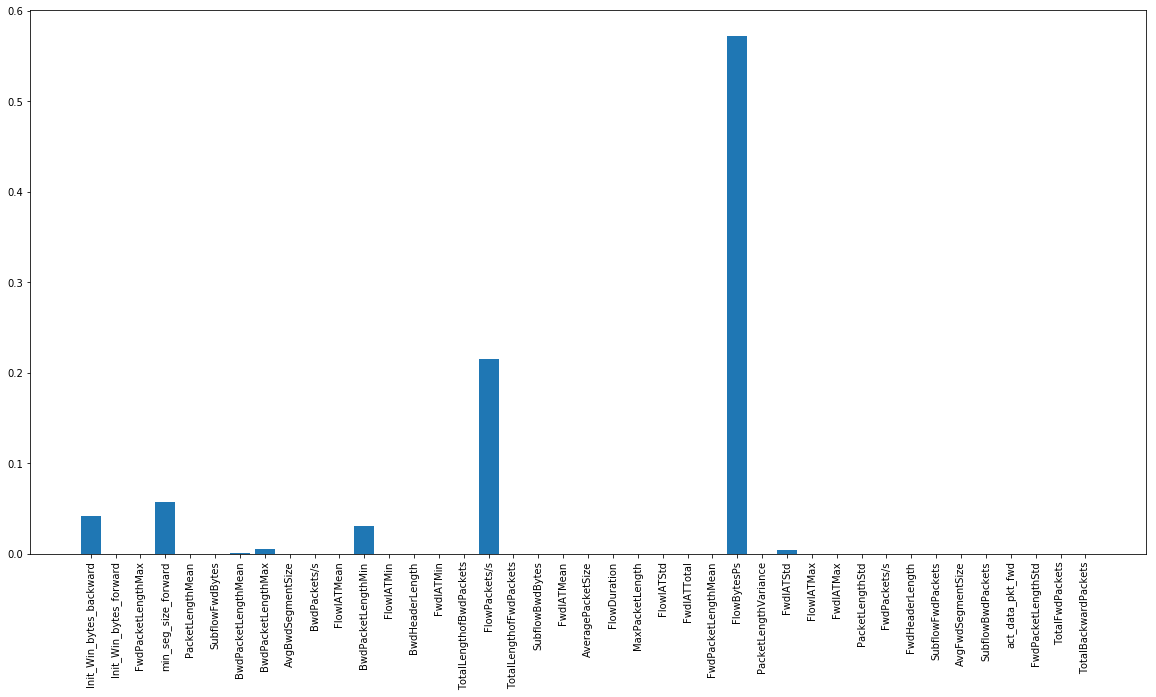

In [72]:
# Plot features contributions in the prediction
L = [contributions[0][i][prediction.argmax()] for i in range(clf_DT.n_features_)]
tick_marks = np.arange(len(list(X_train)))
plt.figure(figsize=(20,10))
plt.xticks(tick_marks, list(X_train), rotation=90)
plt.bar(list(range(clf_DT.n_features_)), L);

## Classifying a new attack - DoS GoldenEye data unknown for the model

In [19]:
novelty_file_path = os.path.join(processed_data_path, 'novelty.csv')
df2 = pd.read_csv(novelty_file_path)
X2_test = df2.drop(columns=['Label'],axis=1)

In [20]:
X2_test.shape

(5083, 41)

In [26]:
%%time
y2_test_pred = clf_RF.predict(X2_test)

Wall time: 218 ms


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished


In [26]:
pd.Series(y2_test_pred).value_counts(normalize=True)

BENIGN                    0.759394
DoS slowloris             0.137124
DoS GoldenEye             0.102695
DoS Hulk                  0.000393
Web Attack Brute Force    0.000197
Web Attack XSS            0.000197
dtype: float64

In [31]:
%%time
y2_test_pred = clf_DT.predict(X2_test)

Wall time: 0 ns


In [32]:
pd.Series(y2_test_pred).value_counts(normalize=True)

BENIGN            0.530592
DoS GoldenEye     0.259492
DoS slowloris     0.171159
PortScan          0.037380
Web Attack XSS    0.000590
DoS Hulk          0.000393
DDoS              0.000393
dtype: float64